<a href="https://colab.research.google.com/github/sgsakthiganesh/GENAI_LAB_PROJECT/blob/main/monkey_pox_prediction_better.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from  tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

In [36]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
# Define paths
data_dir = "/content/drive/MyDrive/NEW_MONKEY_DATA/NEW_MONKEY/archive/Data_Monkeypox"
output_dir = "/content/drive/MyDrive/NEW_MONKEY_DATA"

positive_dir = os.path.join(output_dir, "Positive")
negative_dir = os.path.join(output_dir, "Negative")
# Create output directories
os.makedirs(positive_dir, exist_ok=True)
os.makedirs(negative_dir, exist_ok=True)
# Collect Monkeypox (Positive) Images
for folder in ["AugTrainMonkey", "AugTestmonk", "Trainmonkey", "Testmonkey"]:
    source_folder = os.path.join(data_dir, "AllMonkey", folder)
    if os.path.exists(source_folder):
        for file in os.listdir(source_folder):
            shutil.copy(os.path.join(source_folder, file), positive_dir)
# Collect Not Monkeypox (Negative) Images
for category in ["AllNormal", "AllRoseola", "AllSkarlet"]:
    source_category = os.path.join(data_dir, category)
    for folder in os.listdir(source_category):
        source_folder = os.path.join(source_category, folder)
        if os.path.exists(source_folder):
            for file in os.listdir(source_folder):
                shutil.copy(os.path.join(source_folder, file), negative_dir)
print("Data organized into Positive and Negative classes.")

Data organized into Positive and Negative classes.


In [37]:
import os
import shutil
from sklearn.model_selection import train_test_split
# Directories
base_dir = "/content/drive/MyDrive/Classified_dataset_monkey"
positive_dir = os.path.join(base_dir, "Positive")
negative_dir = os.path.join(base_dir, "Negative")
# Output directories
train_dir = os.path.join(base_dir, "Train")
val_dir = os.path.join(base_dir, "Validation")
test_dir = os.path.join(base_dir, "Test")
# Create subdirectories
for split in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(split, "Positive"), exist_ok=True)
    os.makedirs(os.path.join(split, "Negative"), exist_ok=True)
# Function to split and move files
def split_and_copy(source_dir, train_dest, val_dest, test_dest):
    files = os.listdir(source_dir)
    train_files, temp_files = train_test_split(files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)
    # Copy files
    for f in train_files:
        shutil.copy(os.path.join(source_dir, f), train_dest)
    for f in val_files:
        shutil.copy(os.path.join(source_dir, f), val_dest)
    for f in test_files:
        shutil.copy(os.path.join(source_dir, f), test_dest)
# Split Positive images
split_and_copy(positive_dir,
               os.path.join(train_dir, "Positive"),
               os.path.join(val_dir, "Positive"),
               os.path.join(test_dir, "Positive"))
# Split Negative images
split_and_copy(negative_dir,
               os.path.join(train_dir, "Negative"),
               os.path.join(val_dir, "Negative"),
               os.path.join(test_dir, "Negative"))
print("Dataset split and organized!")

Dataset split and organized!


In [38]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# Directories
train_dir = "/content/drive/MyDrive/Classified_dataset_monkey/Train"
val_dir = "/content/drive/MyDrive/Classified_dataset_monkey/Validation"
test_dir = "/content/drive/MyDrive/Classified_dataset_monkey/Test"
# Image dimensions and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # MobileNet-specific preprocessing
    horizontal_flip=True,
    zoom_range=0.3,
    rotation_range=20,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# Load data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Binary classification
)
val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Keep consistent for evaluation
)


Found 1020 images belonging to 2 classes.
Found 214 images belonging to 2 classes.
Found 220 images belonging to 2 classes.


In [47]:
from tensorflow.keras.applications import MobileNetV2,VGG16, VGG19, InceptionV3, Xception, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# Freeze the base model's layers
base_model.trainable = False

# Add custom layers on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(256, activation=keras.layers.LeakyReLU(negative_slope=0.01)),
    Dropout(0.3),
    Dense(128, activation=keras.layers.LeakyReLU(negative_slope=0.01)),
    Dropout(0.2),
    Dense(64, activation=keras.layers.LeakyReLU(negative_slope=0.01)),
    Dropout(0.1),
    Dense(32, activation=keras.layers.LeakyReLU(negative_slope=0.01)),
    Dropout(0.1),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

call_back=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3, verbose=1, restore_best_weights=True)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,629,185 (10.03 MB)

 Trainable params: 371,201 (1.42 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [48]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_steps=val_data.samples // BATCH_SIZE,
    callbacks=[call_back]
)


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6634 - loss: 0.6264 - val_accuracy: 0.9219 - val_loss: 0.1919
Epoch 2/10
 1/31 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8125 - loss: 0.3656

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8125 - loss: 0.3656 - val_accuracy: 0.9091 - val_loss: 0.2120
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8835 - loss: 0.2871 - val_accuracy: 0.9375 - val_loss: 0.1345
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 1.0000 - loss: 0.0863 - val_accuracy: 0.9545 - val_loss: 0.1215
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9061 - loss: 0.2391 - val_accuracy: 0.9531 - val_loss: 0.1265
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9375 - loss: 0.1998 - val_accuracy: 0.8636 - val_loss: 0.2680
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9118 - loss: 0.2174 - val_accuracy: 0.9688 - val_loss: 0.0816
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.9375 - loss: 0.1180 - val_accuracy: 1.0000 - val_loss: 0.0489
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.9403 - loss: 0.1618 - val_accuracy: 0.9844 - val_loss: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9855 - loss: 0.0484
Test Accuracy: 96.82%
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9599 - loss: 0.0999
Val Accuracy: 97.20%
32/32 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9763 - loss: 0.0895
Train Accuracy: 97.65%
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
               precision    recall  f1-score   support

Not Monkeypox       0.96      0.99      0.97       133
    Monkeypox       0.99      0.93      0.96        87

     accuracy                           0.97       220
    macro avg       0.97      0.96      0.97       220
 weighted avg       0.97      0.97      0.97       220



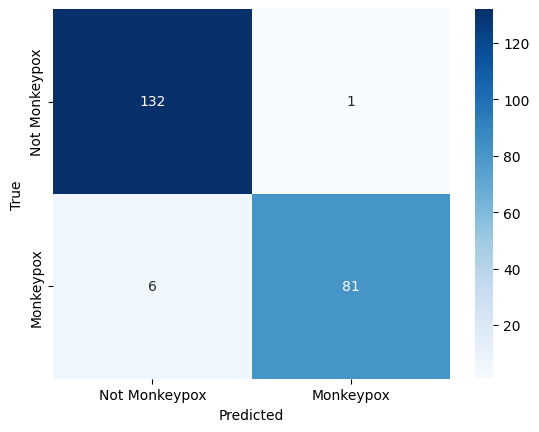

In [49]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

val_loss, val_accuracy = model.evaluate(val_data)
print(f"Val Accuracy: {val_accuracy * 100:.2f}%")

train_loss, train_accuracy = model.evaluate(train_data)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

# Predictions and metrics
from sklearn.metrics import classification_report, confusion_matrix

# Get true labels and predictions
y_true = test_data.classes
y_pred = (model.predict(test_data) > 0.5).astype("int32")

# Generate a classification report
print(classification_report(y_true, y_pred, target_names=['Not Monkeypox', 'Monkeypox']))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_true, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Monkeypox', 'Monkeypox'], yticklabels=['Not Monkeypox', 'Monkeypox'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [53]:
model.save("/content/drive/MyDrive/monkeypox_mobilenet_model.keras")


In [43]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [51]:
image_path='/content/drive/MyDrive/NEW_MONKEY_DATA/Negative/skarlet fever (4).jpg'
img = load_img(image_path, target_size=(224, 224))  # Resize to MobileNet input size
img_array = img_to_array(img)                       # Convert to array
img_array = np.expand_dims(img_array, axis=0)       # Add batch dimension
img_array = preprocess_input(img_array)

In [52]:
prediction = model.predict(img_array)
if prediction[0] > 0.5:
    print("Monkeypox", prediction[0])  # Class 1: Monkeypox
else:
    print("Not Monkeypox", prediction[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Not Monkeypox [0.07080056]
